In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import  GridSearchCV
import xgboost

In [33]:
df=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")
df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


[]

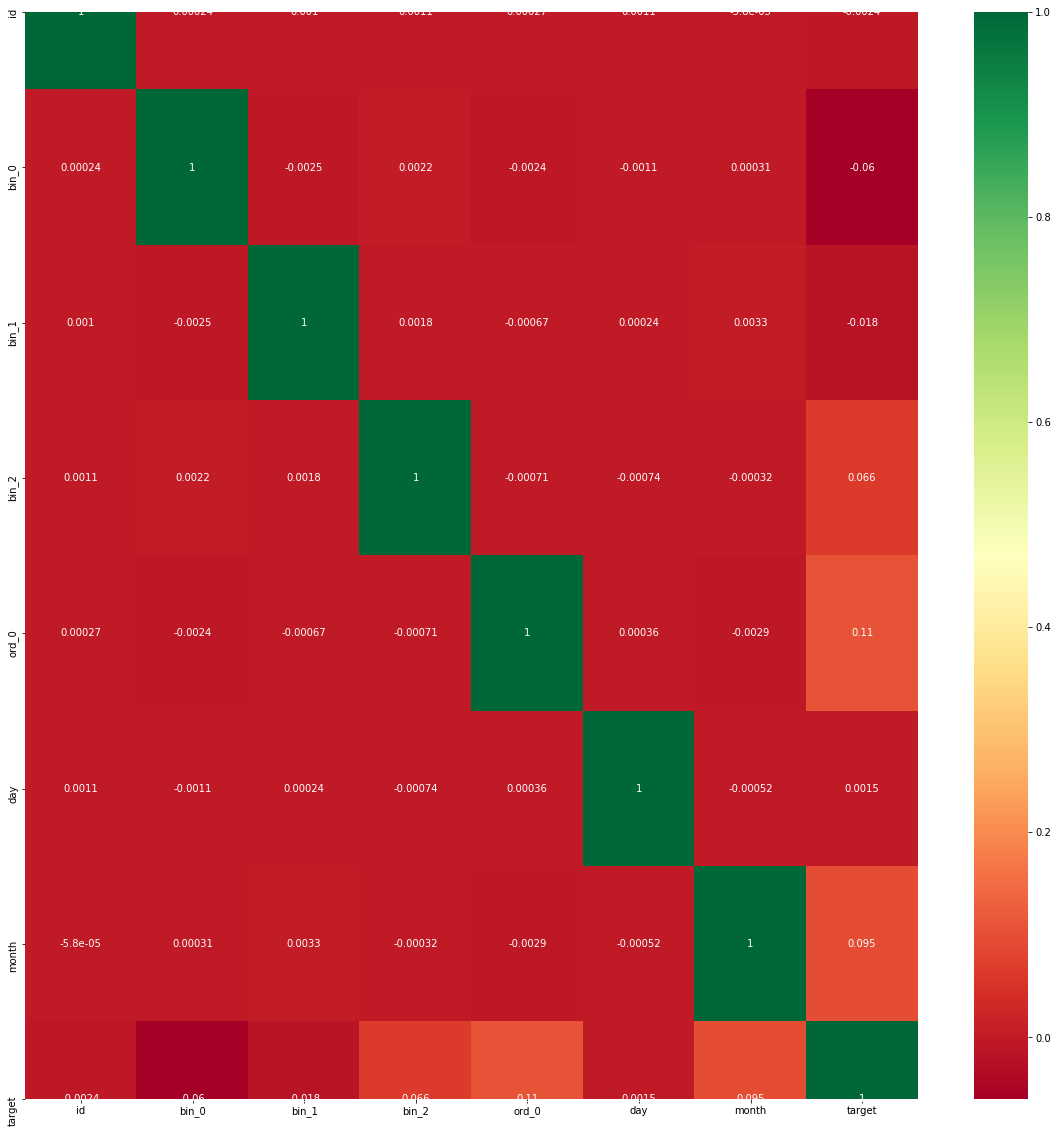

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
# get the correlation of all the features in dataset
corrmat=df.corr()
top_corr_features=corrmat.index
plt.figure(figsize=(20,20))
#plot the heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.plot()

In [4]:
df.bin_1.value_counts(),df.nom_0.value_counts()

(0.0    474018
 1.0    107979
 Name: bin_1, dtype: int64, Red      323286
 Blue     205861
 Green     52601
 Name: nom_0, dtype: int64)

In [6]:
df.ord_2.value_counts()

Freezing       142726
Warm           124239
Cold            97822
Boiling Hot     84790
Hot             67508
Lava Hot        64840
Name: ord_2, dtype: int64

In [7]:
df.day.value_counts()

3.0    113835
5.0    110464
6.0     97432
7.0     86435
1.0     84724
2.0     65495
4.0     23663
Name: day, dtype: int64

In [5]:
df.target.value_counts()

0    487677
1    112323
Name: target, dtype: int64

In [16]:
class categoricalfeature:
    def __init__(self,df,cat_feat,encoding_type,handle_NAN=False):
        #df pandas frames
        #cat_feature: list of categorical feature
        #encoding_type: lable,binary,one_hot
        self.df=df
        self.output_df=self.df.copy(deep=True)
        self.cat_feat=cat_feat
        self.encoding_type=encoding_type
        self.label_encoders=dict()
        
        if handle_NAN:
            for c in self.cat_feat:
                self.df.loc[:,c]= self.df.loc[:,c].astype(str).fillna('-99999')

    def _label_endcoding(self):
        for c in self.cat_feat:
            lbl=preprocessing.LabelEncoder()
            lbl.fit(self.df[c].values)
            self.output_df.loc[:,c]=lbl.transform(self.df[c].values)
            self.label_encoders[c]=lbl
        return self.output_df
            
    def transform(self):
        if self.encoding_type=='label':
            return self._label_endcoding()
        else:
            raise Exception("Encoding type not understand")

In [17]:
cols=[c for c in df.columns if c not in ['id','target']]
cat=categoricalfeature(df,cat_feat=cols,encoding_type='label',handle_NAN=True)
cat_f = categoricalfeature(df_test,cat_feat=cols,encoding_type='label',handle_NAN=True)
df_test = cat_f.transform()
df=cat.transform()

In [18]:
df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,0,0,2,4,3,5,...,27,2,0,3,2,20,56,5,5,0
1,1,1,1,0,0,1,2,3,0,6,...,2112,2,2,5,4,23,151,6,9,0
2,2,0,1,0,0,0,2,6,3,0,...,2218,2,5,2,13,15,105,4,11,0
3,3,2,0,0,0,0,2,0,3,3,...,2167,0,4,4,0,2,140,2,5,0
4,4,0,2,0,1,0,2,5,3,2,...,1747,2,2,1,7,2,50,4,3,0


In [19]:
df.dtypes

id        int64
bin_0     int32
bin_1     int32
bin_2     int32
bin_3     int32
bin_4     int32
nom_0     int32
nom_1     int32
nom_2     int32
nom_3     int32
nom_4     int32
nom_5     int32
nom_6     int32
nom_7     int32
nom_8     int32
nom_9     int32
ord_0     int32
ord_1     int32
ord_2     int32
ord_3     int32
ord_4     int32
ord_5     int32
day       int32
month     int32
target    int64
dtype: object

In [20]:
df.shape,df_test.shape

((600000, 25), (400000, 24))

In [21]:
x=df.drop(['target','id'],axis=1)
y=df['target']

In [ ]:
import time
start = time.time()
p={
    'learning_rate':[0.1,0.9,0.8,0.7],
    'max_depth':[7,8,10],
    'reg_lambda':[1, 0.1, 0.5, 0.9],
    'gamma':[i/10.0 for i in range(0,5)],
    
}

x=xgboost.XGBClassifier(n_estimators=100,objective= 'binary:logistic', seed=27)
gsearch7 = GridSearchCV(estimator = x, 
 param_grid = p, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch7.fit(df[cols],df['target'])
gsearch7.best_params_, gsearch7.best_score_

end = time.time()
print((end - start)//60,"mins")

In [22]:
x.dtypes

bin_0    int32
bin_1    int32
bin_2    int32
bin_3    int32
bin_4    int32
nom_0    int32
nom_1    int32
nom_2    int32
nom_3    int32
nom_4    int32
nom_5    int32
nom_6    int32
nom_7    int32
nom_8    int32
nom_9    int32
ord_0    int32
ord_1    int32
ord_2    int32
ord_3    int32
ord_4    int32
ord_5    int32
day      int32
month    int32
dtype: object

In [26]:
%%time
import xgboost 
from sklearn.metrics import accuracy_score
skf = StratifiedKFold(n_splits=10,shuffle=True)
skf.get_n_splits(x, y)
accuracy=[]

clf=xgboost.XGBClassifier(colsample_bytree= 0.6, gamma=0.09, learning_rate= 0.21, max_depth= 7, min_child_weight= 3, 
                          reg_alpha= 0, reg_lambda= 1, subsample=0.8,n_estimators= 175,scale_pos_weight=1)


for train_index, test_index in skf.split(x, y):
    print("TRAIN:", train_index)
    print("TEST:", test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(x_train,y_train)
    pred=clf.predict(x_test)
    zscore=accuracy_score(pred,y_test)
    accuracy.append(zscore)
print(accuracy)

TRAIN: [     0      1      2 ... 599996 599997 599999]
TEST: [     5     12     23 ... 599956 599962 599998]
TRAIN: [     1      2      4 ... 599997 599998 599999]
TEST: [     0      3     14 ... 599973 599986 599995]
TRAIN: [     0      1      3 ... 599997 599998 599999]
TEST: [     2     24     27 ... 599958 599968 599992]
TRAIN: [     0      1      2 ... 599995 599998 599999]
TEST: [     8     11     13 ... 599990 599996 599997]
TRAIN: [     0      1      2 ... 599997 599998 599999]
TEST: [    17     34     67 ... 599981 599982 599988]
TRAIN: [     0      1      2 ... 599997 599998 599999]
TEST: [     9     16     19 ... 599974 599979 599989]
TRAIN: [     0      2      3 ... 599997 599998 599999]
TEST: [     1     32     33 ... 599971 599975 599983]
TRAIN: [     0      1      2 ... 599997 599998 599999]
TEST: [     6      7     25 ... 599961 599977 599991]
TRAIN: [     0      1      2 ... 599997 599998 599999]
TEST: [     4     10     18 ... 599964 599984 599994]
TRAIN: [     0     

In [28]:
test=df_test.drop(['id'],axis=1)
y_pred=clf.predict(test)

In [29]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [30]:
len(y_pred)

400000

In [31]:
sample = pd.read_csv("sample_submission.csv")
sample.loc[:, "target"] = y_pred
sample.to_csv("submission_using_xgboost.csv", index=False)

In [ ]:
accuracy= 0.55  #on the test data

In [ ]:
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

In [ ]:
%%time
from sklearn.impute import SimpleImputer

cols_with_missing_train_data = [col for col in df.columns if df[col].isnull().any()]
cols_with_missing_test_data = [col for col in df_test.columns if df_test[col].isnull().any()]


t = SimpleImputer(strategy='most_frequent')
train_data[cols_with_missing_train_data] = t.fit_transform(df[cols_with_missing_train_data])
test_data[cols_with_missing_test_data] = t.fit_transform(df[cols_with_missing_test_data])



In [ ]:
%%time
train_data.to_csv("train_data.csv",index=False)
test_data.to_csv("test_data.csv",index=False)